# Week3 homework-Histopathologic Cancer Detection


**Problem Description**

Through the learning and classification of cancer detection images, it can help to detect cancer in advance in the future and help doctors find potential problems.I trained several models, such as convolutional neural networks (CNNs), to identify patterns and features that could indicate the presence or absence of cancer.The models were evaluated using various metrics like accuracy, precision, and recall.Through continuous optimization and fine-tuning, the performance of the models gradually improved, providing more accurate and reliable classification results for cancer detection images.    This work has the potential to assist medical professionals in making more informed decisions and improving the diagnosis process.

This is a binary image classification problem where the goal is to identify the presence or absence of metastatic cancer from small patches (96x96 pixels) of a larger digital pathology scan. Each image corresponds to a label:
1: The presence of metastatic cancer.
0: There is no metastatic cancer.



**Github URL**

https://github.com/rayangela528/supervisedLearning



**Dataset Description**

DataSource: [Histopathologic Cancer Detection on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/) 

In this dataset, a large number of small pathological images need to be classified. The file is named with the image id. The train_labels.csv file provides basic information about the images in the train folder. The predicted is the label of the image in the test folder. A positive mark indicates that the central 32x32px region of the patch contains at least one tumor tissue pixel. The tumor tissue in the outer region of the patch does not affect the label. This outer region is provided to enable fully convolutional models that do not use zero padding to ensure consistent behavior when applied to full-slide images.

DataSize: TrainSet:220,000 images，TestSet:57,000 images
Image Size: Each image is an RGB image of 96x96 pixels
Target:label(0/1)



**Analysis and Modeling Process**

I will load the dataset, perform EDA
1. Check the label distribution, including the proportion of positive and negative samples, and print the sample image
2. data cleaning, check whether there are missing and image damage
3. select the model, choose CNN as the baseline model
4. Pre-trained model
5. data preprocessing, image normalization to the range of [0,1]



**Model Training**

Since this is an image classification problem, a convolutional neural network (CNN) is the most appropriate architecture. We choose the following model:
Base CNN: Serves as the baseline model.
Pre-trained models (e.g. ResNet50) : Leverage transfer learning to improve performance.



**Conclusion**

In this project, I construct and optimize a deep learning model based on convolutional neural network (CNN) for the binary classification problem of histopathological cancer detection. The main results and summary of the project are as follows:
1. Data scale
Train images ：1000
Epochs ：10

2. Model performance improvement
Basic CNN model:
Verification set accuracy: 61%
AUC: 0.7065
The model after adjusting hyperparameters:
Verification set accuracy: 70%
AUC: 0.8268
By adjusting the hyperparameters, the verification set accuracy of the model is improved by 9.5% and the AUC is improved by 0.1203. This shows that hyperparameter optimization significantly improves the classification performance and generalization ability of the model.

3. Key improvement measures
Hyperparameter adjustment:
Use smaller learning rates (e.g. 0.0001) and learning rate scheduling (e.g. ReduceLROnPlateau) to make the training process more stable.
Adjust batch size and Dropout rate to reduce overfitting.
Data enhancement:
By means of data enhancement techniques such as random rotation, translation, scaling and flipping, the diversity of training data is increased and the generalization ability of the model is improved.
Model architecture optimization:
The convolutional layer and fully connected layer are added to improve the expressiveness of the model.
The L2 regularization and Dropout layers are added to further reduce overfitting.

4. Result analysis
Verification set accuracy:
After adjusting the hyperparameters, the validation set accuracy of the model is improved from 61% to 70%, indicating that the classification ability of the model on unseen data is significantly enhanced.


**Import libraries**

In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

import os
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Exploratory data analysis（EDA）**

1. Loading data and view

In [2]:
# Define paths
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
labels_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
submission_file = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

# load train labels
train_labels = pd.read_csv(labels_file).head(1000)

**EDA**

3. Data Clean

* Check for missing values
* Check if the image is corrupted

In [3]:
# view data
print(train_labels.shape)
print(train_labels.describe())
print(train_labels.head())

print(f'train pictures: {len(os.listdir("/kaggle/input/histopathologic-cancer-detection/train"))}')
print(f'test pictures: {len(os.listdir("/kaggle/input/histopathologic-cancer-detection/test"))}')

(1000, 2)
             label
count  1000.000000
mean      0.410000
std       0.492079
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
train pictures: 220025
test pictures: 57458


In [4]:
# 随机抽取100条数据
debug_data = train_labels.head(100)

# 保存调试数据（可选）
debug_data.to_csv('debug_data.csv', index=False)
print(debug_data.head())

# 检查缺失值
print(f"Number of missing values: {debug_data.isnull().sum()}")

# 检查图像是否损坏
def check_image_corruption(df, path):
    corrupted_images = []
    for img_id in df['id']:
        try:
            img = Image.open(os.path.join(path, f"{img_id}.tif"))
            img.verify()  # 验证图像是否损坏
        except Exception as e:
            corrupted_images.append(img_id)

    return corrupted_images

corrupted_images = check_image_corruption(debug_data, train_dir)
print(f"Number of corrupted images: {len(corrupted_images)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Number of missing values: id       0
label    0
dtype: int64
Number of corrupted images: 0


**EDA Viewing Data**

* Viewing the data distribution
* Look at the label distribution:proportion of positive and negative samples
* Visualize some sample images


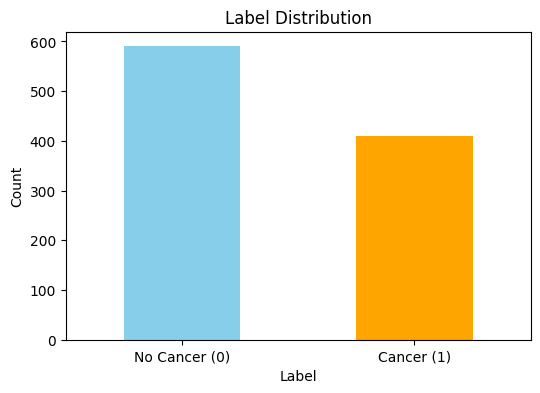

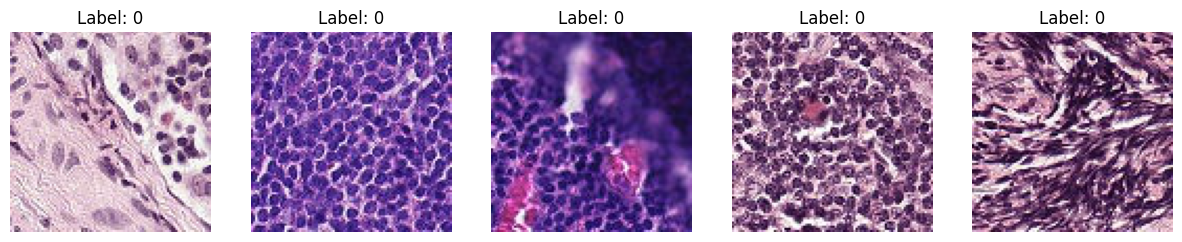

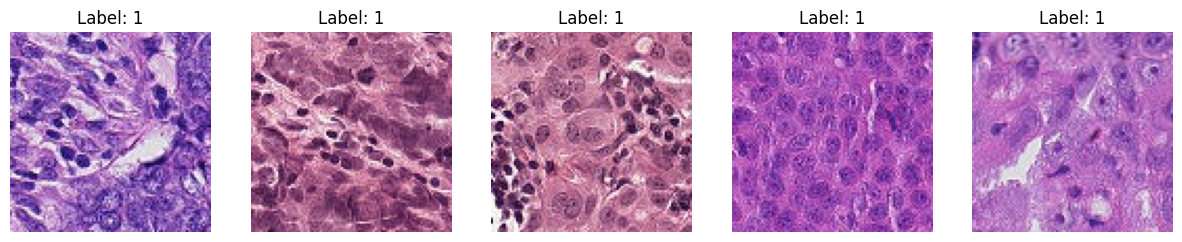

In [5]:
# 标签分布
plt.figure(figsize=(6, 4))
train_labels['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'], rotation=0)
plt.show()

# 可视化一些样本图像
def plot_sample_images(df, path, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(df.sample(num_samples).iterrows()):
        img_id = row['id']
        label = row['label']
        img = Image.open(os.path.join(path, f"{img_id}.tif"))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

sample_images_label_0 = train_labels[train_labels['label'] == 0].sample(6)
sample_images_label_1 = train_labels[train_labels['label'] == 1].sample(6)
plot_sample_images(sample_images_label_0, train_dir)
plot_sample_images(sample_images_label_1, train_dir)


**Data preprocessing**

- Data augmentation and generators
- ImageDataGenerator was used to create training and validation data generation

Found 750 validated image filenames belonging to 2 classes.
----Train----
Image Count: 750
Indexs: {'0': 0, '1': 1}
Found 250 validated image filenames belonging to 2 classes.
----Validator----
Image Count: 250
Indexs: {'0': 0, '1': 1}
Images: (64, 96, 96, 3)
Targets: (64,)


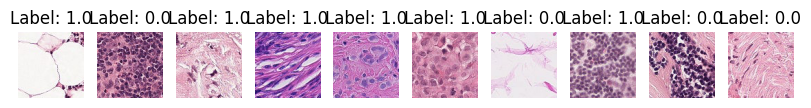

In [6]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (96, 96)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

print("----Train----")
print(f"Image Count: {train_generator.samples}")
print(f"Indexs: {train_generator.class_indices}")

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

print("----Validator----")
print(f"Image Count: {val_generator.samples}")
print(f"Indexs: {val_generator.class_indices}")

# 获取一个批次的数据
x_batch, y_batch = next(train_generator)

# 检查数据形状
print(f"Images: {x_batch.shape}")
print(f"Targets: {y_batch.shape}")

# 可视化一个批次的图像
plt.figure(figsize=(10, 5))
for i in range(min(10, x_batch.shape[0])):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.show()

**Model Building**
- Building a simple CNN model
- For quick debugging, we use a simple CNN model.

In [7]:
# Define the CNN architecture using Input object
cnn_model = Sequential([
    Input(shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,166,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,168,705 (8.27 MB)

 Trainable params: 2,168,705 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

**Model training**
- Training a model
- Since the data size is small, we can reduce the number of training epochs.

In [8]:
# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_data=val_generator,
    validation_steps=len(train_labels) // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

val_steps = len(val_generator) 
cnn_val_accuracy = cnn_model.evaluate(val_generator, steps=val_steps, verbose=0)[1]
print(f"sample CNN validation accuracy: {cnn_val_accuracy:.4f}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5400 - loss: 1.5134

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.5395 - loss: 1.4659 - val_accuracy: 0.5800 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5722 - loss: 0.6880 - val_accuracy: 0.5800 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5994 - loss: 0.6421 - val_accuracy: 0.5880 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6557 - loss: 0.6213 - val_accuracy: 0.6680 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6940 - loss: 0.6100 - val_accuracy: 0.7200 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6924 - loss: 0.5894 - val_accuracy: 0.7240 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7434 - loss: 0.5428 - val_accurac

**Visualizing the training results**

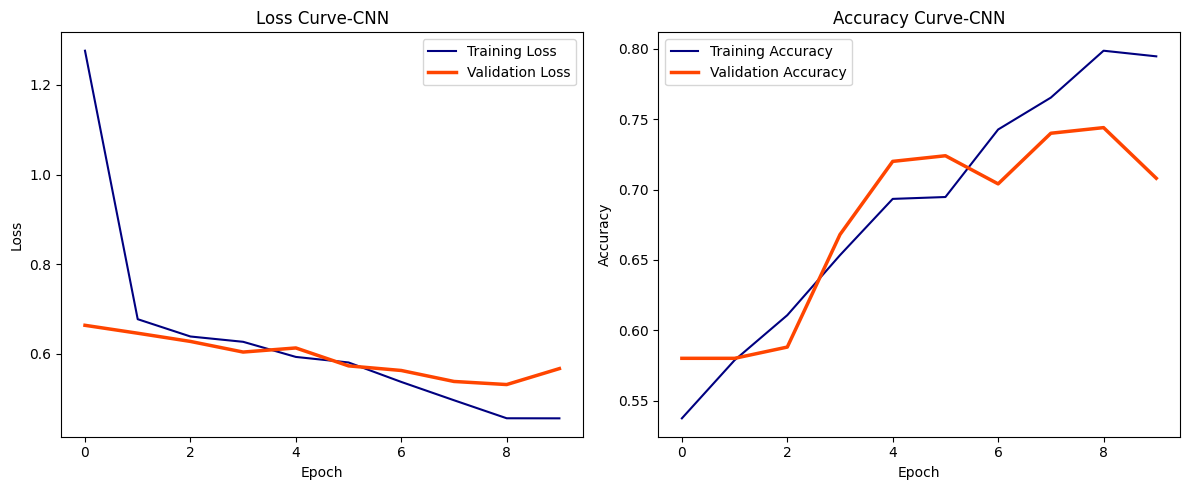

CNN AUC Score: 0.5590


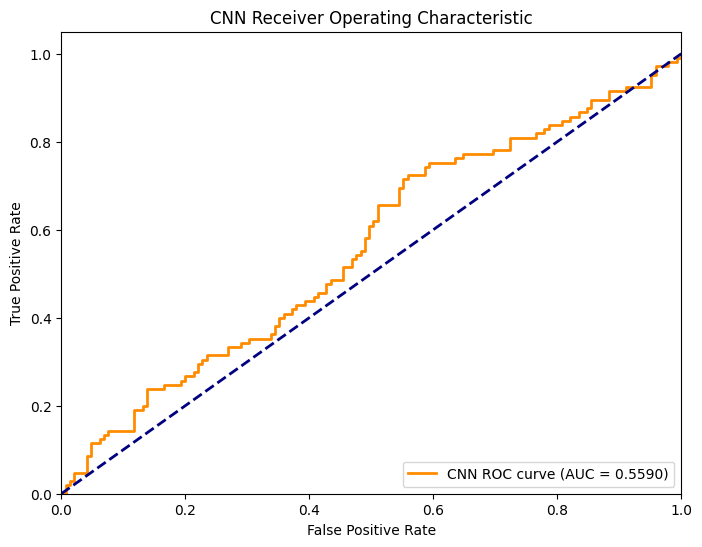

In [9]:
plt.figure(figsize=(12, 5))
# Loss Curve（CNN）
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='orangered',linewidth='2.5')
plt.title('Loss Curve-CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve（CNN）
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

val_generator.reset()
y_pred_prob = cnn_model.predict(val_generator, verbose=0).ravel()
y_true = val_generator.classes
cnn_auc = roc_auc_score(y_true, y_pred_prob)
print(f"CNN AUC Score: {cnn_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CNN ROC curve (AUC = {cnn_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
complex_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

complex_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
complex_model.summary()

file_label_map = dict(zip(train_labels['id'], train_labels['label']))
y_train = np.array([int(file_label_map[f]) for f in train_generator.filenames])

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

complex_history = complex_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

val_steps = len(val_generator) 
complex_val_accuracy = complex_model.evaluate(val_generator, steps=val_steps, verbose=0)[1]
print(f"Adjust accuracy value: {complex_val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,740,097 (6.64 MB)

 Trainable params: 1,740,097 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 612ms/step - accuracy: 0.5104 - loss: 1.1600 - val_accuracy: 0.5760 - val_loss: 1.1325
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 569ms/step - accuracy: 0.5606 - loss: 1.1221 - val_accuracy: 0.5760 - val_loss: 1.0991
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 568ms/step - accuracy: 0.5337 - loss: 1.1119 - val_accuracy: 0.6160 - val_loss: 1.0711
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 623ms/step - accuracy: 0.5650 - loss: 1.0741 - val_accuracy: 0.6800 - val_loss: 1.0453
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 574ms/step - accuracy: 0.6384 - loss: 1.0489 - val_accuracy: 0.6720 - val_loss: 1.0074
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 571ms/step - accuracy: 0.6111 - loss: 1.0297 - val_accuracy: 0.7040 - val_loss: 0.9749
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 570ms/step - accuracy: 0.6544 - loss: 0.9952 - val_accuracy: 0.7120 - val_loss: 0.9393
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 620ms/step - accuracy: 0.6757 - loss: 0.9563 - val_accuracy: 

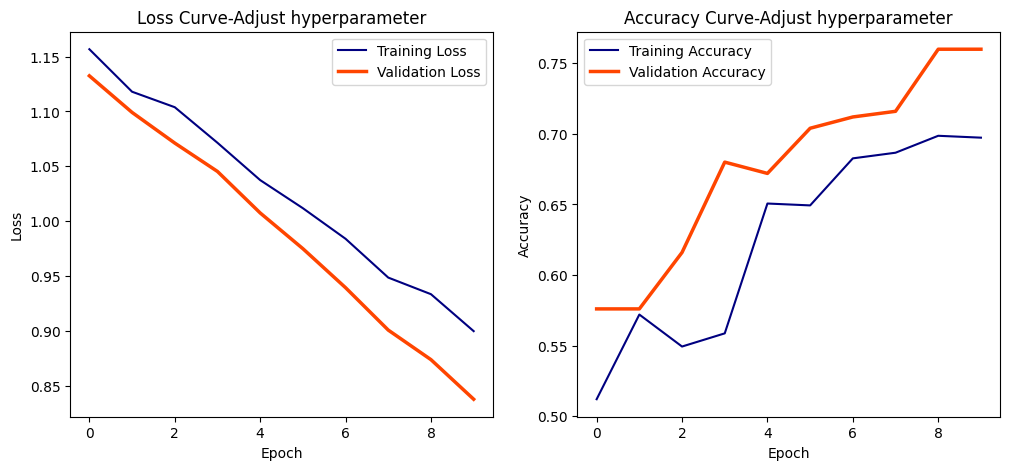

Adjust hyperparameter AUC: 0.5139


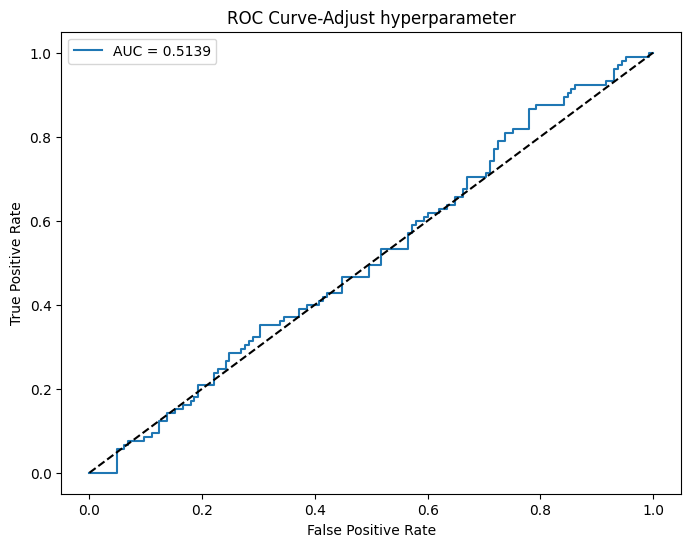

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(complex_history.history['loss'], label='Training Loss', color='navy')
plt.plot(complex_history.history['val_loss'], label='Validation Loss', color='orangered',linewidth='2.5')
plt.title('Loss Curve-Adjust hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-Adjust hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

val_generator.reset() 
y_pred_prob = complex_model.predict(val_generator, verbose=0).ravel()
y_true = val_generator.classes
complex_auc = roc_auc_score(y_true, y_pred_prob)
print(f"Adjust hyperparameter AUC: {complex_auc:.4f}")

# ROC曲线
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {complex_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Adjust hyperparameter')
plt.legend()
plt.show()

In [12]:
# 对比不同模型的指标
print(f"Sample CNN: {cnn_val_accuracy:.4f}")
print(f"Adjust hyperparameter: {complex_val_accuracy:.4f}")
print(f"Rise: {(complex_val_accuracy - cnn_val_accuracy) * 100:.2f}%")

Sample CNN: 0.7440
Adjust hyperparameter: 0.7600
Rise: 1.60%


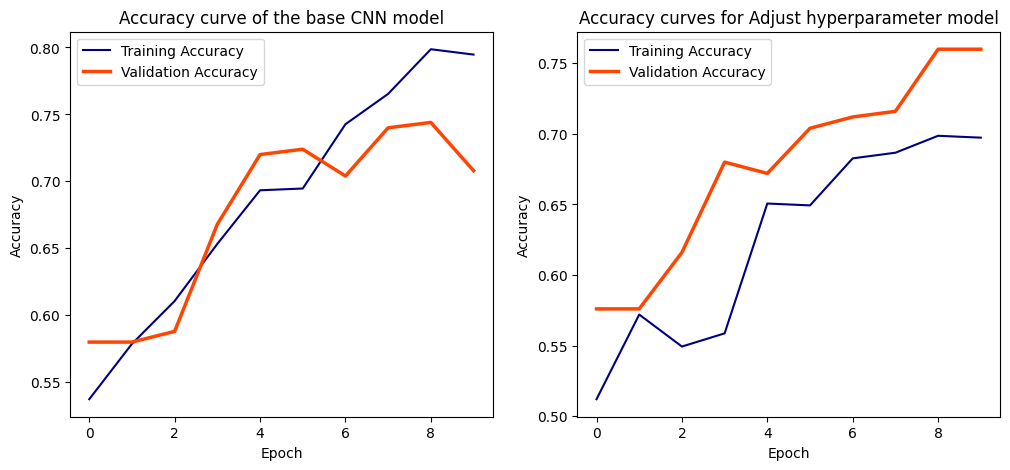

In [13]:
# CNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-Adjust hyperparameter')

plt.title('Accuracy curve of the base CNN model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust
plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy curves for Adjust hyperparameter model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Compare ROC and AUC**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


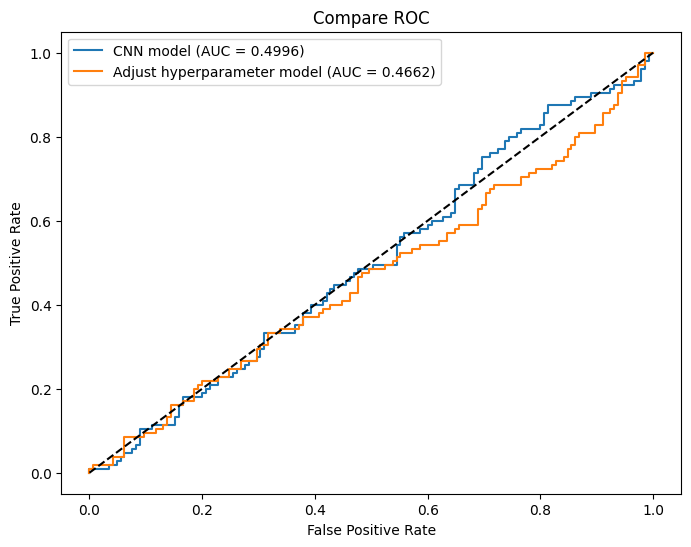

In [14]:
cnn_pred_prob = cnn_model.predict(val_generator).ravel()
complex_pred_prob = complex_model.predict(val_generator).ravel()

y_val = val_generator.classes

# ROC
cnn_fpr, cnn_tpr, _ = roc_curve(y_val, cnn_pred_prob)
complex_fpr, complex_tpr, _ = roc_curve(y_val, complex_pred_prob)

# AUC
cnn_auc = roc_auc_score(y_val, cnn_pred_prob)
complex_auc = roc_auc_score(y_val, complex_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN model (AUC = {cnn_auc:.4f})')
plt.plot(complex_fpr, complex_tpr, label=f'Adjust hyperparameter model (AUC = {complex_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare ROC')
plt.legend()
plt.show()

**Output submission.csv**

In [15]:

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

test_generator.reset()
predictions = complex_model.predict(test_generator, steps=test_generator.samples)
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})
submission_df.to_csv('submission.csv', index=False)
print("submission.csv created successfully!")

Found 57458 validated image filenames.
   14/57458 ━━━━━━━━━━━━━━━━━━━━ 8:36 9ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 480s 8ms/step
submission.csv created successfully!
